In [86]:
import PIL
from PIL import Image, ImageDraw, ImageTk
import cv2 as cv
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\USER\AppData\Local\Programs\Tesseract-OCR\tesseract.exe'
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()
import tkinter as tk
from tkinter import filedialog

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


# INPUT

In [74]:
def UploadAction(event=None):
    global filename
    filename = filedialog.askopenfilename(filetypes=[('png images','.png'), ('jpg images','.jpg')])
    print('Selected:', filename)
    root.destroy()
    
root = tk.Tk()
button = tk.Button(root, text='Upload your ID', command=UploadAction)
button.pack()

root.mainloop()

Selected: C:/Users/User/InstituteID.jpg


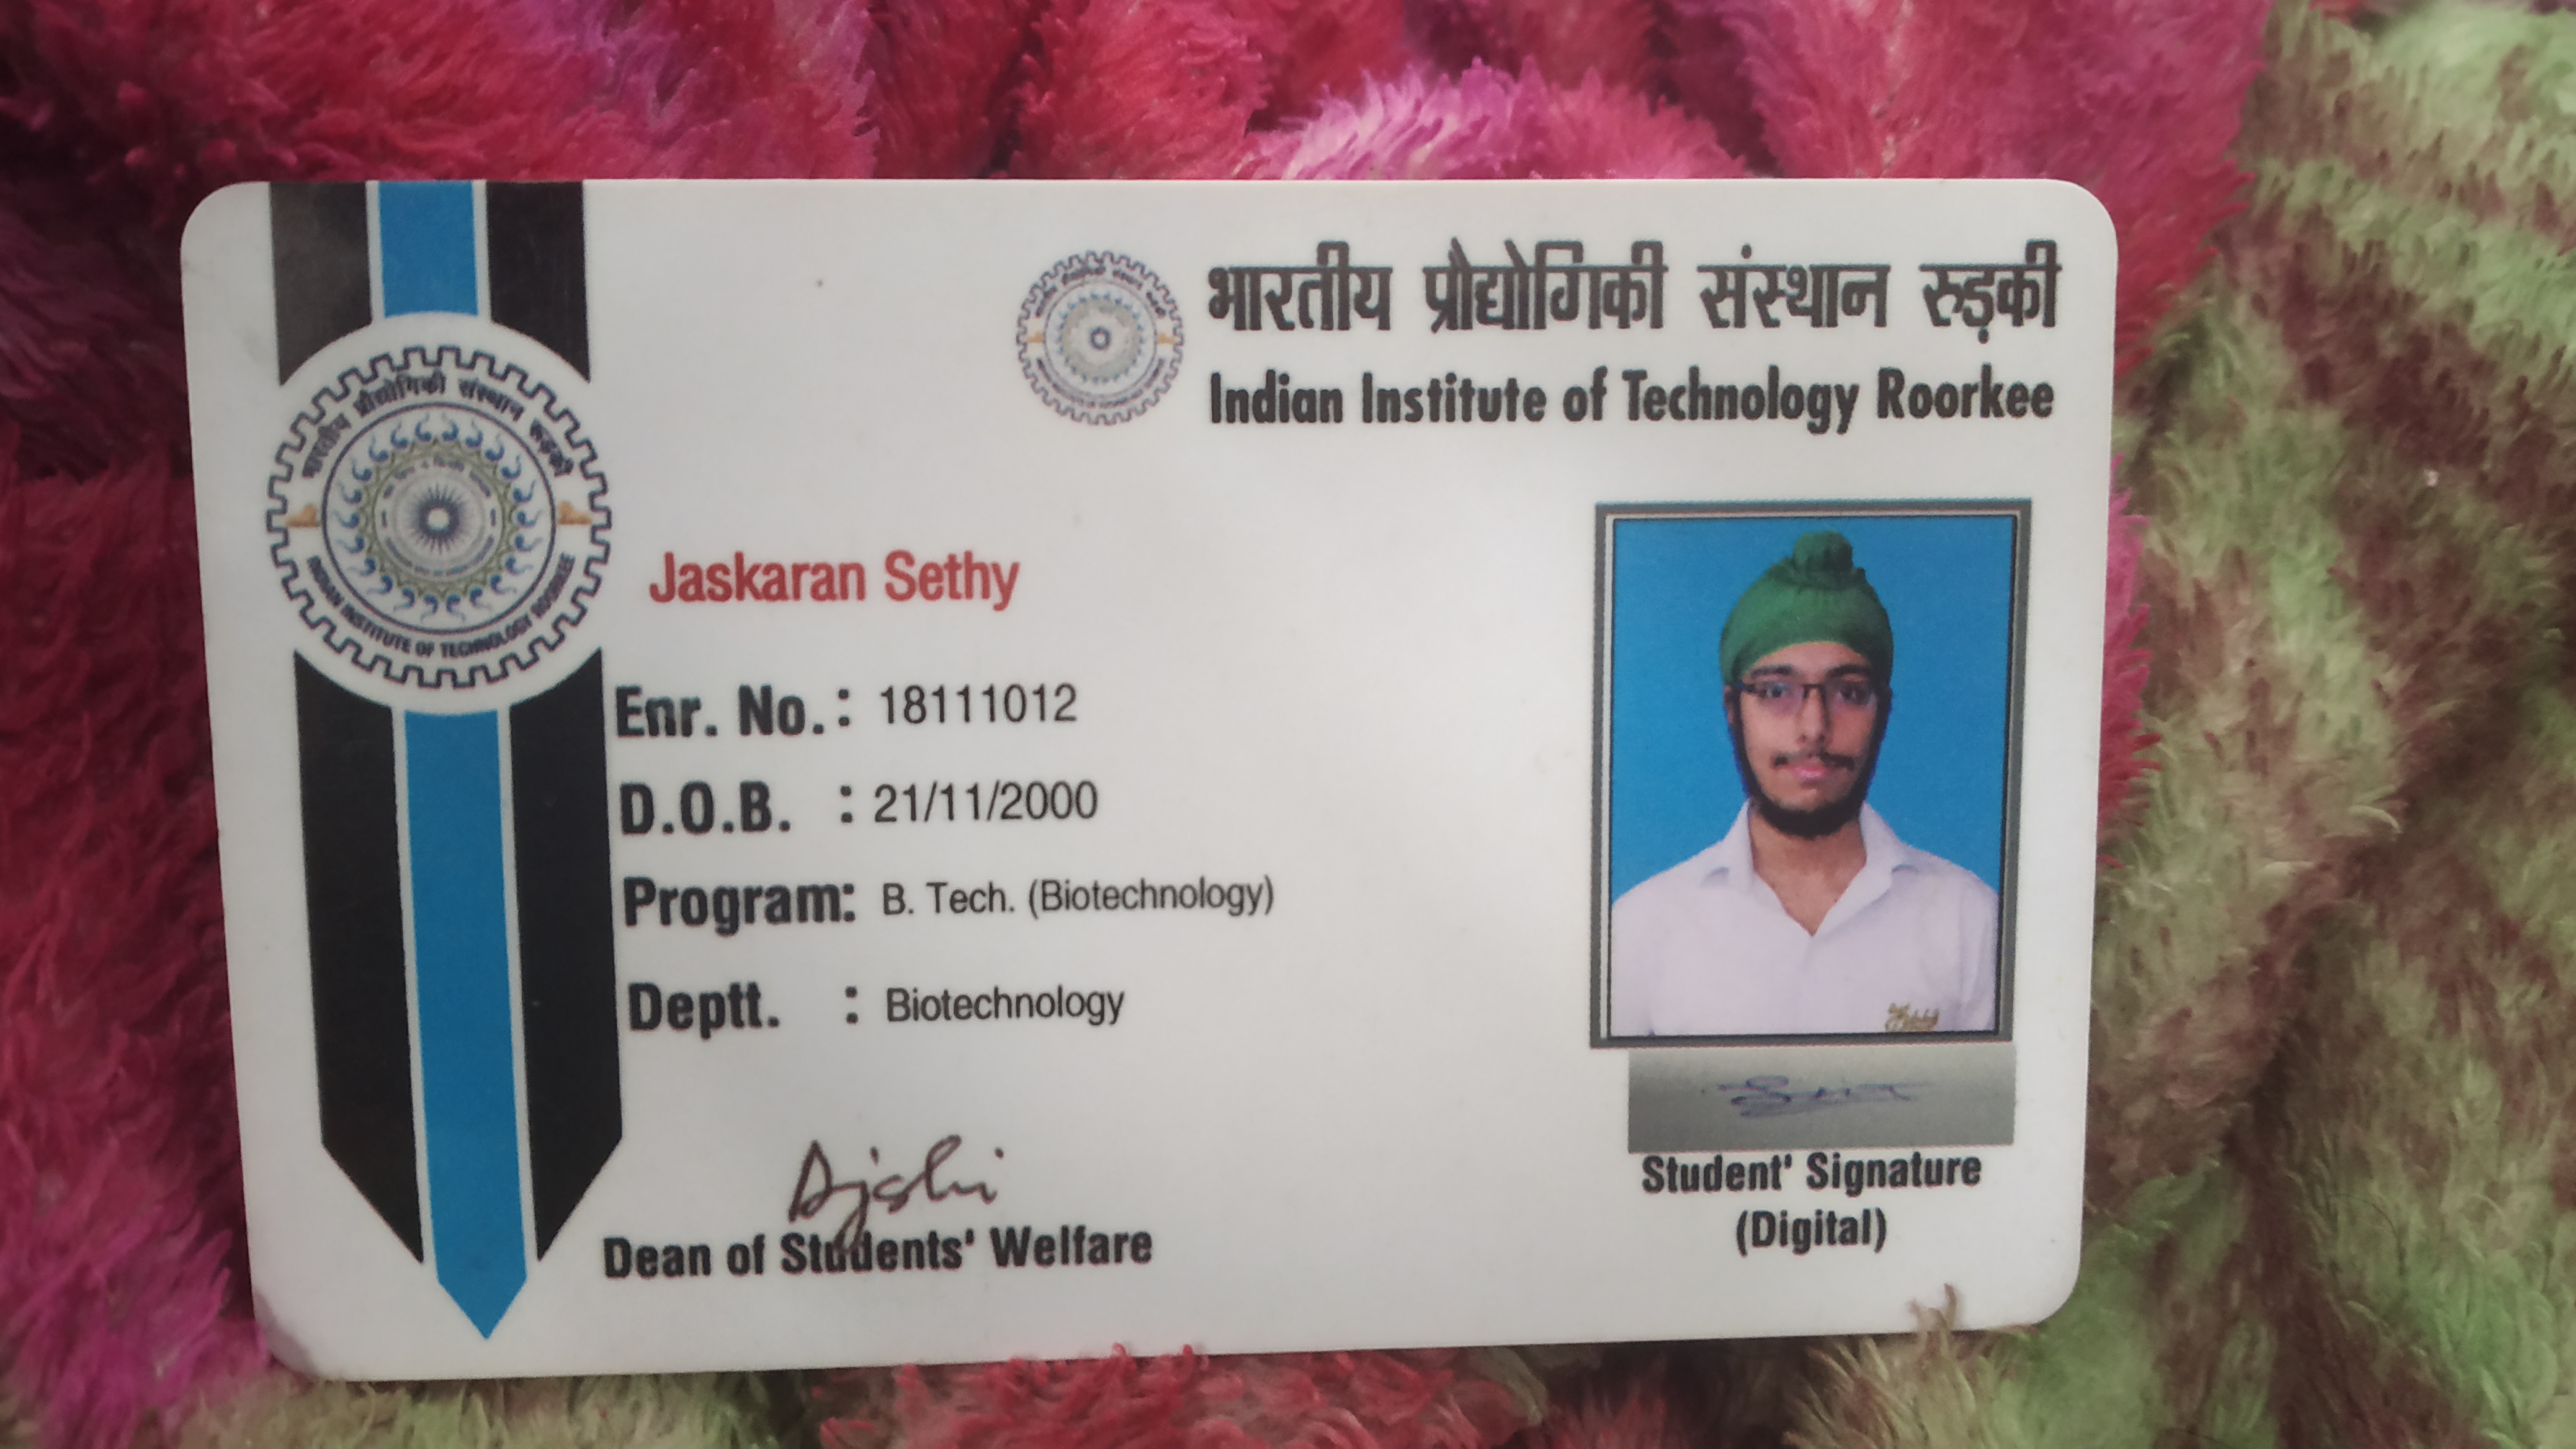

In [65]:
# Input

idcardcv = cv.imread(filename)
idcard = Image.open(filename)

display(idcard)

In [66]:
def binarize(image, threshold):
    output = image.convert('L')
    output = output.point(lambda x: x > threshold and 255)
    return output


grayId = idcard.convert('L')
defaultBinarizedId = idcard.convert('1')
binarizedIds = [binarize(grayId, threshold) for threshold in np.linspace(0,255,4)]

ids = [grayId] + binarizedIds + [defaultBinarizedId]

# Text and Image Recognition

In [67]:
#OCR

texts = [pytesseract.image_to_string(idc) for idc in ids]


In [68]:
recognizers = [nlp(text) for text in texts]

In [69]:
labellist = [dict([(str(x), x.label_) for x in recognizer.ents]) for recognizer in recognizers]

print(labellist)

[{'Jaskaran Sethy': 'PERSON', '18111012': 'DATE', '8': 'CARDINAL', '7': 'CARDINAL', 'Dean': 'PERSON', '‘ Welfare (Digital': 'ORG'}, {}, {'Hiecila': 'GPE', 'Sgebl': 'ORG', 'Indian Institute of Technology Roorkee': 'ORG', '4\n\n': 'MONEY', '18111012': 'DATE', '0': 'CARDINAL', 'B. Tech': 'PERSON', 'Dean': 'PERSON', 'Digital': 'ORG', '9\n\n \n\x0c': 'CARDINAL'}, {'3': 'CARDINAL', '18111012': 'DATE', '21/11/2000': 'DATE', 'B. Tech': 'PERSON'}, {}, {}]


In [70]:
persons=[]
dates=[]
orgs=[]
cardinals=[]
for dic in labellist:
    for x in dic.keys():
        if dic[x] == 'PERSON':
            persons.append(x.strip())
        if dic[x] == 'DATE':
            dates.append(x.strip())
        if dic[x] == 'ORG':
            orgs.append(x.strip())
        if dic[x] == 'CARDINAL':
            cardinals.append(x.strip())
persons = list(set([x for x in persons if len(x)>7]))
dob = list(set([x for x in dates if '-' in x or '/' in x or ',' in x]))
numbers = list(set([x for x in dates if (len(x)>3 and x not in dob)] + [x for x in cardinals if (len(x)>3 and x not in dob)]))
        


In [71]:
cvGrayId = cv.cvtColor(idcardcv, cv.COLOR_BGR2GRAY)
faceCascade = cv.CascadeClassifier('cvdata/haarcascade_frontalface_alt.xml')
faces = faceCascade.detectMultiScale(cvGrayId)

In [88]:
if faces.size != 0:
    face = faces[0]
    width, height = cvGrayId.shape
    photo = idcard.crop((face[0]-0.05*width,face[1]-0.05*height,(face[0]+face[2])+0.05*width,(face[1]+face[3])+0.05*height))
else:
    photo = 'Photo Not Found'

# OUTPUT

In [97]:
root = tk.Tk()
root.title("ID Card Details")
root.minsize(200,200)
root.maxsize(500,500)
tkName = tk.Label(root, text='Names: '+" ,".join(persons))
tkDates = tk.Label(root, text='Dates: '+" ,".join(dob))
tkNumbers = tk.Label(root,text='Numbers: '+ ','.join(numbers))
tkPhoto = ImageTk.PhotoImage(photo.resize((100,100)))
tkPhotoDisplay = tk.Label(image=tkPhoto)
tkPhotoDisplay.image=tkPhoto
closingButton = tk.Button(root, text='Close Window', command=root.destroy)
tkName.pack()
tkDates.pack()
tkNumbers.pack()
tkPhotoDisplay.pack()
closingButton.pack()

root.mainloop()
